In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objs as go

In [49]:
df_apple = pd.read_csv("AAPL_new.csv")
df_apple

,Date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,1999-11-01,80.00,80.6900,77.37,77.62,0.589041,2487300,0.0,1.0
1,1999-11-02,78.00,81.6900,77.31,80.25,0.608999,3564600,0.0,1.0
2,1999-11-03,81.62,83.2500,81.00,81.50,0.618485,2932700,0.0,1.0
3,1999-11-04,82.06,85.3700,80.62,83.62,0.634574,3384700,0.0,1.0
4,1999-11-05,84.62,88.3700,84.00,88.31,0.670165,3721500,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5882,2023-03-20,155.07,157.8200,154.15,157.40,157.400000,73641415,0.0,1.0
5883,2023-03-21,157.32,159.4000,156.54,159.28,159.280000,73938285,0.0,1.0
5884,2023-03-22,159.30,162.1400,157.81,157.83,157.830000,75701811,0.0,1.0
5885,2023-03-23,158.83,161.5501,157.68,158.93,158.930000,67622060,0.0,1.0


In [50]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple.set_index('Date', inplace=True)

In [53]:
df_apple = df_apple[['close']]
df_apple

,close
Date,
1999-11-01,77.62
1999-11-02,80.25
1999-11-03,81.50
1999-11-04,83.62
1999-11-05,88.31
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


In [65]:
df_new = df_apple.copy()

In [66]:
df_new = df_new.drop(df_new.index[:1000])
df_new

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


### EDA

(array([10957., 12418., 13879., 15340., 16801., 18262., 19723.]),
 [Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024')])

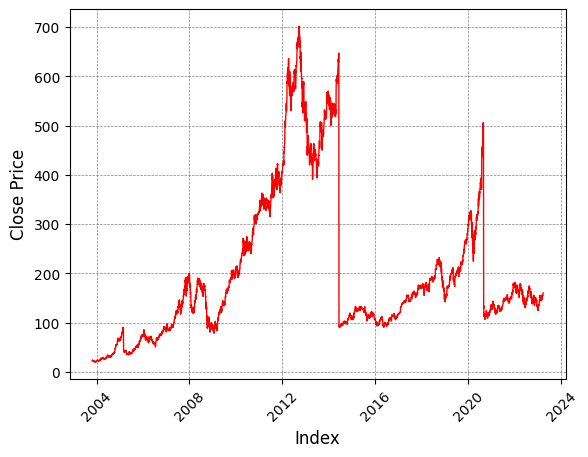

In [7]:
plt.plot(df_new,color='red', linewidth=1, linestyle='-')
plt.xlabel('Index', fontsize=12)
plt.ylabel('Close Price', fontsize=12)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray') 
plt.xticks(rotation=45)

### Let's capture Trends, seasonality and Noise in the Dataset.

In [8]:
from statsmodels.tsa.seasonal import STL

stl = STL(df_new["close"], period=12) 
res = stl.fit()
seasonal, trend, residual = res.seasonal, res.trend, res.resid

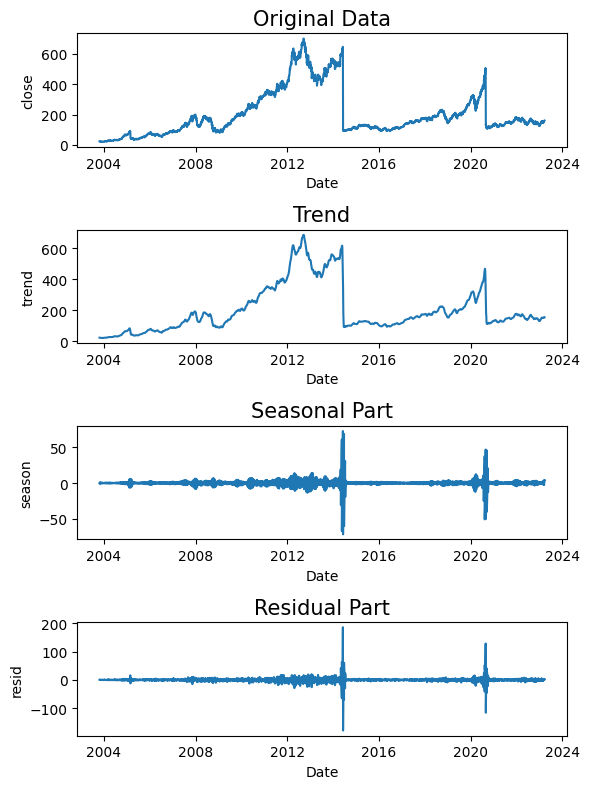

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 8))

plt.subplot(4, 1, 1)
sns.lineplot(x=df_new.index, y=df_new['close'])
plt.title('Original Data', fontsize=15)

plt.subplot(4, 1, 2)
sns.lineplot(x=trend.index, y=trend)
plt.title('Trend', fontsize=15)

# Plot 3 - Seasonal
plt.subplot(4, 1, 3)
sns.lineplot(x=seasonal.index, y=seasonal)
plt.title('Seasonal Part', fontsize=15)

# Plot 4 - Residual
plt.subplot(4, 1, 4)
sns.lineplot(x=residual.index, y=residual)
plt.title('Residual Part', fontsize=15)

plt.tight_layout()
plt.show()


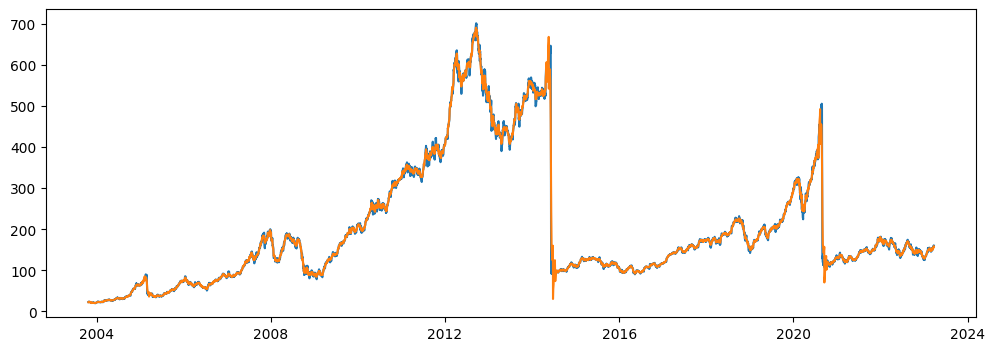

In [10]:
estimated_data = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_new)
plt.plot(estimated_data)

### Anomaly detection Using STL techniques

In [11]:
mu_residual = residual.mean()
resid_dev = residual.std()

lower = mu_residual - 3*resid_dev
upper = mu_residual + 3*resid_dev

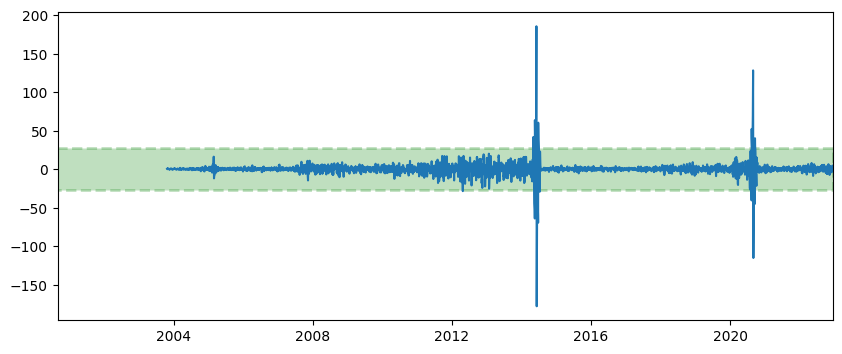

In [12]:
import datetime
plt.figure(figsize=(10,4))
plt.plot(residual)

plt.fill_between([datetime.datetime(2000,1,1), datetime.datetime(2022,12,12)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime.datetime(2000,9,1), datetime.datetime(2022,12,12))

plt.show()

In [13]:
anomalies = df_new[(residual < lower) | (residual > upper)]
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2012-04-24 to 2020-09-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


In [14]:
anomalies.head()

,close
Date,
2012-04-24,560.28
2014-05-05,600.96
2014-05-06,594.41
2014-05-15,588.82
2014-05-16,597.51


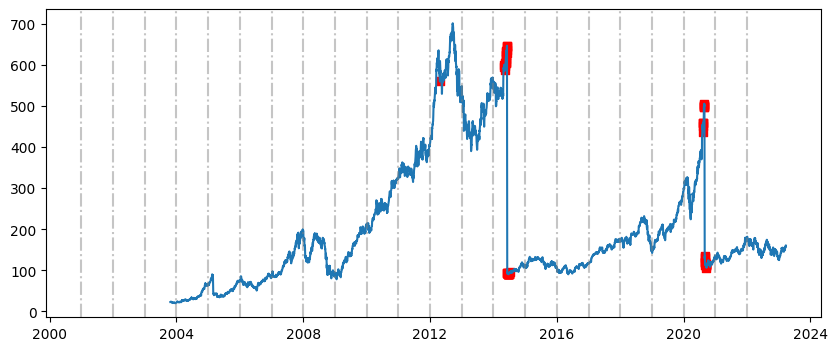

In [15]:
plt.figure(figsize=(10,4))
plt.plot(df_new)
for years in range(2001,2023):
    plt.axvline(datetime.datetime(years,1,1), color='gray', linestyle='-.', alpha=0.45)
    
plt.scatter(anomalies.index, anomalies.close, color='red', marker='s')
plt.show()

### Now let's use LSTM to find anomlaies

In [16]:
train_size = int(len(df_new) * 0.80) #80% of the dataframe will be used for training
test_size = len(df_new) - train_size #20% of the dataframe will be used for testing
train, test = df_new.iloc[0:train_size], df_new.iloc[train_size:len(df_new)]
train

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2019-05-01,210.52
2019-05-02,209.15
2019-05-03,211.75


In [17]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler = scaler.fit(train[['close']]) 

train['close'] = scaler.transform(train[['close']]) #Transforming the 'Close' column in train data.
test['close'] = scaler.transform(test[['close']])

<ipython-input-17-49c784edd6af>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']]) #Transforming the 'Close' column in train data.
<ipython-input-17-49c784edd6af>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [18]:
TIME_STEP = 30

def create_seq(X, y, time_steps=TIME_STEP):
    """
    Creates sequential data for LSTM model training.
    time_steps (int): The number of time steps for each sequence.

    Returns:
    tuple: A tuple containing the sequential input data and target variable.
    """
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_seq(train[['close']], train['close'])
X_test, y_test = create_seq(test[['close']], test['close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')


Training shape: (3879, 30, 1)
Testing shape: (948, 30, 1)


### Hyper-Parameter Tuning

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

def create_model(units=128, dropout_rate=0.2, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=dropout_rate))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(units=64, activation=activation, return_sequences=True))
    model.add(Dropout(rate=dropout_rate))
    model.add(TimeDistributed(Dense(X_train.shape[2])))
    model.compile(optimizer=optimizer, loss='mae')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {'units': [64,128],
              'dropout_rate': [0.1,0.2],
              'activation': ['relu'],
              'optimizer': ['adam']}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-19-ed6ba0e197a4>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.734907 using {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'adam', 'units': 128}


### Final Model using Best parameters

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential()

# Add LSTM layer with adjusted hyperparameters
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))

# Compile the model
model.compile(optimizer='adam', loss='mae')

In [30]:
from tensorflow import keras
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/10
110/110 [==============================] - 9s 53ms/step - loss: 0.3668 - val_loss: 0.0584
Epoch 2/10
110/110 [==============================] - 5s 43ms/step - loss: 0.2376 - val_loss: 0.2185
Epoch 3/10
110/110 [==============================] - 6s 51ms/step - loss: 0.1814 - val_loss: 0.1338
Epoch 4/10
110/110 [==============================] - 5s 44ms/step - loss: 0.1710 - val_loss: 0.0652


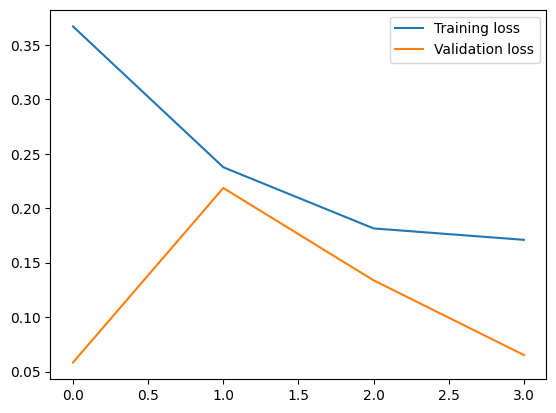

In [31]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [32]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 13ms/step - loss: 0.1652


0.16517972946166992

Reconstruction error threshold: 0.5310288669875827


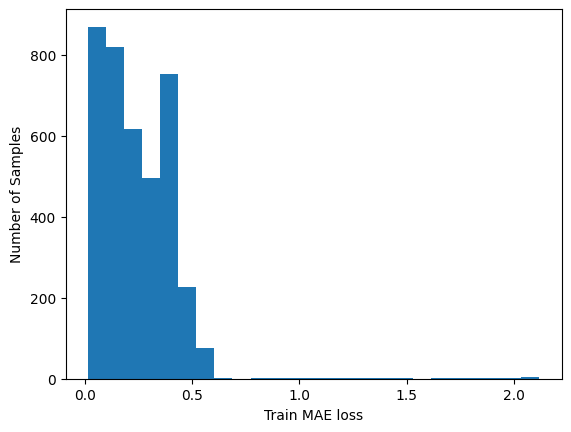

In [33]:
Xtrain_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(Xtrain_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=25)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
threshold = np.percentile(train_mae_loss,98)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 1.3869654724622942


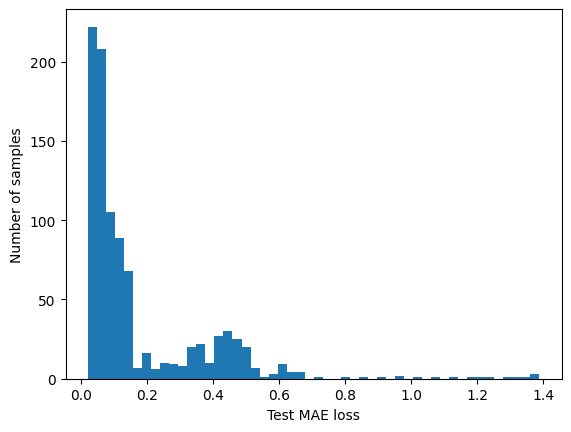

In [34]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
threshold_test = np.max(test_mae_loss)
print(f'Reconstruction error threshold: {threshold_test }')

In [36]:
test_score_df = pd.DataFrame(test[TIME_STEP:])
test_score_df

,close
Date,
2019-06-20,-0.028922
2019-06-21,-0.033059
2019-06-24,-0.034276
2019-06-25,-0.052588
2019-06-26,-0.026853
...,...
2023-03-20,-0.284813
2023-03-21,-0.273376
2023-03-22,-0.282197


In [38]:
test_score_df = pd.DataFrame(test[TIME_STEP:])
test_score_df['Date'] = test_score_df.index
test_score_df['loss'] = test_mae_loss
threshold = 0.53
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['close'] = test[TIME_STEP:]['close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [39]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(41, 5)

In [57]:
anomalies

,close,Date,loss,threshold,anomaly
Date,,,,,
2020-08-05,1.436038,2020-08-05,0.533843,0.53,True
2020-08-06,1.529487,2020-08-06,0.552947,0.53,True
2020-08-07,1.461590,2020-08-07,0.580813,0.53,True
2020-08-10,1.500893,2020-08-10,0.586126,0.53,True
2020-08-11,1.419307,2020-08-11,0.597864,0.53,True
2020-08-12,1.507768,2020-08-12,0.593705,0.53,True
2020-08-13,1.556439,2020-08-13,0.598400,0.53,True
2020-08-14,1.553945,2020-08-14,0.604840,0.53,True
2020-08-17,1.546644,2020-08-17,0.610095,0.53,True


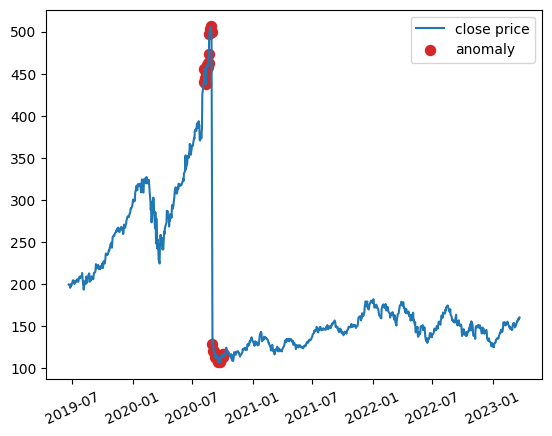

In [41]:
plt.plot(
  test[TIME_STEP:].index, 
  scaler.inverse_transform(test[TIME_STEP:].close.values.reshape(-1, 1)), 
  label='close price'
)

plt.scatter(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.values.reshape(-1, 1)),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()

In [42]:
df_new

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


### Removing anomalies from Dataframe.

In [67]:
anomaly_dates = anomalies[anomalies['anomaly']]['Date']
df_new = df_new[~df_new.index.isin(anomaly_dates)]

In [68]:
df_new

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


In [70]:
df_anom_removed = df_new.copy()

In [71]:
df_anom_removed

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


### Forecasting Using LSTM

In [72]:
forecast_df = df_anom_removed['close'].iloc[:-4]

In [73]:
import math
train_len = math.ceil(len(forecast_df)*0.8)
train_len

3874

In [74]:
window=10

train_data = forecast_df[0:train_len]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [75]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [76]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3864, 10, 1)

In [77]:
from keras.layers import Dense, LSTM, Dropout

In [78]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 50)                10400     
                                                                 
 dense_24 (Dense)            (None, 25)                1275      
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [80]:
test_data = forecast_df[train_len-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [81]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [82]:
prediction = model.predict(X_val)

31/31 [==============================] - 0s 2ms/step


In [83]:
len(prediction), len(Y_val)

(968, 968)

In [84]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

31/31 [==============================] - 0s 3ms/step
Train rmse: 11.85084245922398
Validation rmse: 11.757672216347899


### I have ran the model without removing anomalies, I got a rmse of 13.81, now after anomlaies removed, I got 11.75. Lot of improvement and yes feature engineering techniques worked pretty well !!

In [86]:
valid = pd.DataFrame(forecast_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,close,Predictions
Date,,
2019-03-19,186.53,181.326111
2019-03-20,188.16,182.147568
2019-03-21,195.09,183.268372
2019-03-22,191.05,186.163300
2019-03-25,188.74,187.451828
...,...,...
2023-03-14,152.59,149.049118
2023-03-15,152.99,149.838501
2023-03-16,155.85,150.641891


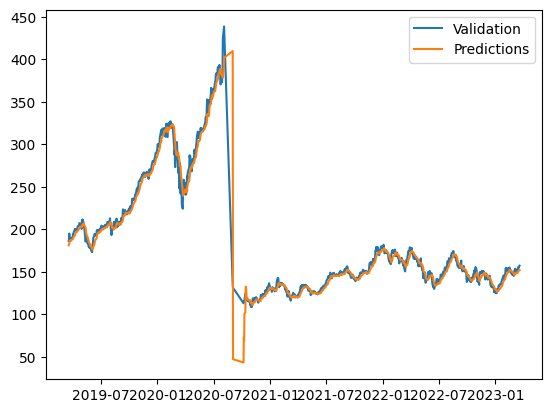

In [87]:
plt.plot(valid[['close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()